In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Initialize Spark Session
spark = (SparkSession.builder
         .appName("Collision_Victim_Analysis")
         .config("spark.executor.memory", "4g")  # Increase executor memory
         .config("spark.executor.cores", "2")  # Number of cores per executor
         .config("spark.driver.memory", "4g")  # Increase driver memory
         .getOrCreate())
# Load cleaned collision data
collision_df = spark.read.csv("clean_collision_records.csv", header=True, inferSchema=True)

# Load cleaned victim data
victim_df = spark.read.csv("clean_victim_records.csv", header=True, inferSchema=True)

# Verify loaded data
collision_df.show(5)
victim_df.show(5)

+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|           CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|     PRIMARY_RD|   SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|
+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|100010101011401155|         2001| 20010416| 0100|      20010101|           114|      1155|                 0|          1|         4|          198|        0|            0|      DUBLIN BL|    SCARLETT CT|     267|        W|           N|
|100010103174503131|         2001| 20010416| 0100|      

In [4]:
from pyspark.sql.functions import when

# Join the datasets on CASE_ID
combined_df = collision_df.join(victim_df, "CASE_ID", "inner")


# Show the joined data
combined_df.show(10)
print("Total records after join:", combined_df.count())

# change victim degree of injury to binary values
combined_df = combined_df.withColumn("INJURY_SEVERITY_BINARY", when((combined_df["VICTIM_DEGREE_OF_INJURY"] == 1) | (combined_df["VICTIM_DEGREE_OF_INJURY"] == 2), 1).otherwise(0))

# drop reporting district column - unused
cols_to_drop = ['REPORTING_DISTRICT']
combined_df = combined_df.drop(*cols_to_drop)

+-------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+----------+------------+--------+---------+------------+------------+-----------+----------+----------+-----------------------+-----------------------+--------------------+--------------------+--------------+
|CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|PRIMARY_RD|SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|PARTY_NUMBER|VICTIM_ROLE|VICTIM_SEX|VICTIM_AGE|VICTIM_DEGREE_OF_INJURY|VICTIM_SEATING_POSITION|VICTIM_SAFETY_EQUIP1|VICTIM_SAFETY_EQUIP2|VICTIM_EJECTED|
+-------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+----------+------------+--------+---------+------------+------------+-----------+----------+----------

Total records after join: 18616027


In [4]:
combined_df.printSchema()


root
 |-- CASE_ID: decimal(20,0) (nullable = true)
 |-- ACCIDENT_YEAR: integer (nullable = true)
 |-- PROC_DATE: integer (nullable = true)
 |-- JURIS: string (nullable = true)
 |-- COLLISION_DATE: integer (nullable = true)
 |-- COLLISION_TIME: integer (nullable = true)
 |-- OFFICER_ID: string (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- POPULATION: integer (nullable = true)
 |-- CNTY_CITY_LOC: integer (nullable = true)
 |-- BEAT_TYPE: integer (nullable = true)
 |-- CHP_BEAT_TYPE: string (nullable = true)
 |-- PRIMARY_RD: string (nullable = true)
 |-- SECONDARY_RD: string (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- DIRECTION: string (nullable = true)
 |-- INTERSECTION: string (nullable = true)
 |-- PARTY_NUMBER: integer (nullable = true)
 |-- VICTIM_ROLE: string (nullable = true)
 |-- VICTIM_SEX: string (nullable = true)
 |-- VICTIM_AGE: integer (nullable = true)
 |-- VICTIM_DEGREE_OF_INJURY: string (nullable = true)
 |-- VICTIM_SEATING_POSITION

24/12/19 01:10:30 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


R2 (coefficient of determination): 0.32068964267187217


24/12/19 01:11:05 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB
24/12/19 01:12:38 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


Root Mean Squared Error (RMSE): 16.18121702292452


24/12/19 01:13:06 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB
24/12/19 01:14:30 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


Mean Absolute Error (MAE): 12.559761087434781

=== Feature Coefficients ===
COLLISION_TIME: -0.13794
VICTIM_SEATING_POSITION_vec: 4.95198
VICTIM_SAFETY_EQUIP2_vec: 2.91227
VICTIM_EJECTED_vec: -8.80319
DIRECTION_vec: 2.49882
VICTIM_SEX_vec: -9.96571
PRIMARY_RD_vec: -13.54944
SECONDARY_RD_vec: 1.41308
VICTIM_ROLE_vec: 3.08589


24/12/19 01:14:58 WARN DAGScheduler: Broadcasting large task binary with size 24.0 MiB
24/12/19 01:16:56 WARN DAGScheduler: Broadcasting large task binary with size 25.2 MiB


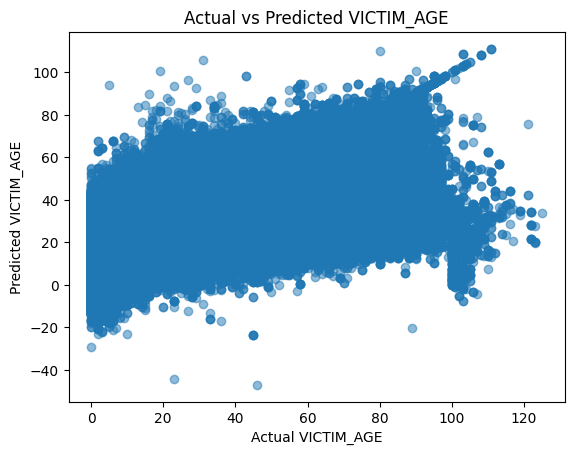

In [5]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import when, col

# Feature Engineering
encoded_columns = ["VICTIM_SEATING_POSITION", "VICTIM_SAFETY_EQUIP2", "VICTIM_EJECTED",
                   "DIRECTION", "VICTIM_SEX", "PRIMARY_RD", "SECONDARY_RD","VICTIM_ROLE"]
numerical_columns = [ "COLLISION_TIME"]

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c + "_index", handleInvalid='skip') for c in encoded_columns]
encoders = [OneHotEncoder(inputCol=c + "_index", outputCol=c + "_vec") for c in encoded_columns]

# Scale numerical features
assembler_numerical = VectorAssembler(inputCols=numerical_columns, outputCol="numerical_features")
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_numerical_features", withMean=True, withStd=True)

# Combine all features into a single vector
feature_columns = ["scaled_numerical_features"] + [c + "_vec" for c in encoded_columns]
assembler_final = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler_numerical, scaler, assembler_final])

#Prepare Data
prepared_df = pipeline.fit(combined_df).transform(combined_df)

# Target: VICTIM_AGE
final_df = prepared_df.select("features", "VICTIM_AGE")

# Show transformed data
final_df.show(5, truncate=False)

# Train-test Split
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="VICTIM_AGE", predictionCol="prediction")
lr_model = lr.fit(train_data)

#Evaluate the Model
predictions = lr_model.transform(test_data)
evaluator_r2 = RegressionEvaluator(labelCol="VICTIM_AGE", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="VICTIM_AGE", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="VICTIM_AGE", predictionCol="prediction", metricName="mae")

print("R2 (coefficient of determination):", evaluator_r2.evaluate(predictions))
print("Root Mean Squared Error (RMSE):", evaluator_rmse.evaluate(predictions))
print("Mean Absolute Error (MAE):", evaluator_mae.evaluate(predictions))

# Feature Importance (Approximated by Coefficients)
coefficients = lr_model.coefficients
feature_names = numerical_columns + [c + "_vec" for c in encoded_columns]

print("\n=== Feature Coefficients ===")
for feature, coeff in zip(feature_names, coefficients):
    print(f"{feature}: {coeff:.5f}")

# Visualize Predictions
import matplotlib.pyplot as plt

actual = predictions.select("VICTIM_AGE").rdd.flatMap(lambda x: x).collect()
predicted = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

plt.scatter(actual, predicted, alpha=0.5)
plt.xlabel("Actual VICTIM_AGE")
plt.ylabel("Predicted VICTIM_AGE")
plt.title("Actual vs Predicted VICTIM_AGE")
plt.show()
